#### Import / Global Vars

In [129]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [130]:
#imports section
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
from mvo_utils_v2 import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [131]:
# L/S utility functions
# calculates max drawdown, largest reduction from highest point
def max_drawdown(xs):
    i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
    j = np.argmax(xs[:i]) # start of period
    if log:
        plt.plot(xs)
        plt.plot([i, j], [xs[i], xs[j]], 'x', color='Red', markersize=10)
    return -1 * ((xs[j] - xs[i]) / xs[j])[0], j, i
# long-short version of recommend allocations
def ls_recommend_allocs(px, lb, net_exp, lev, min_w, max_w, gamma_val):
    px = clean_nas(px) # clean dataframe
    px_portion = px[-lb:].copy() # subselect the period to optimize; frame and lb were duplicatives
    returns, alloc = ls_get_weights(
        px_portion, lb, net_exp, lev, min_w, max_w, gamma_val) # subselect the period to optimize
    port_perf = calc_port_performance(returns.values, alloc.values)
    pdf = pd.DataFrame(port_perf, index=returns.index, columns=["Quantum"])
    return px_portion, returns, alloc, pdf
# long-short version of optimization, position weights
def ls_get_weights(px, lb, min_sum, max_sum, min_w, max_w, gamma_val):
    lb_rets = px.sort_index().pct_change().fillna(0) # capture the last lb days going back
    n = lb_rets.shape[1]; mu = lb_rets.mean().values.T; Sigma = lb_rets.cov().values
    w = cvx.Variable(n)
    gamma = cvx.Parameter(sign='positive')
    Lmax = cvx.Parameter()
    ret = mu.T * w; risk = cvx.quad_form(w, Sigma)
    lo_obj = cvx.Maximize(ret - gamma*risk)
    #lo_const = [cvx.sum_entries(w) >= min_sum, cvx.sum_entries(w) <= max_sum, w > min_w, w < max_w]
    ls_const = [cvx.sum_entries(w) >= min_sum, cvx.norm(w, 1) < Lmax, w <= max_w, w >= min_w]
    prob = cvx.Problem(lo_obj, ls_const)
    gamma.value = gamma_val; Lmax.value = max_sum
    prob.solve()
    weights = w.value if prob.status == 'optimal' else np.zeros((n, 1))
    np_weights = np.array(weights)
    lb_weights = pd.DataFrame(np_weights.T, index=[lb_rets.index[-1]], columns=lb_rets.columns)
    return lb_rets, lb_weights
# pending implementation using partials
def quick_gamma(glist, px, lb, net_exp, lev, min_w, max_w):
    if len(glist) <= 1: 
        mid_g = glist[0]
        mid_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_g)
        return mid_g, mid_sr
    else:
        mid = len(glist)//2; left = glist[:mid]; right = glist[mid:]
        mid_l = left[len(left)//2]; mid_r = right[len(right)//2]
        left_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_l)
        right_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_r)
        sublist = left if left_sr > right_sr else right
        #if left_sr > right_sr: sublist = left
        #else: sublist = right
        return quick_gamma(sublist, px, lb, net_exp, lev, min_w, max_w)
# return portfolio sharpe for a given optimization
def get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, gamma):
    px_p, _, alloc, pdf = ls_recommend_allocs(px, lb, net_exp, lev, min_w, max_w, gamma)
    rec = last_allocation(alloc, 0.01)
    ret, risk = port_metrics(px_p, rec)
    return ret / risk
# cleans small positions in long-short portfolios based on minimum weight criteria
def filter_ls(rec, pos_filter):
    long = rec[(rec > pos_filter).values]; short = rec[(rec < -pos_filter).values]
    return long.append(short)
#calculates the historical allocations based on a date frequency
def get_hist_allocs(rebal_freq, px, lb, g_samples, min_len, pos_filter):
    px = clean_nas(px)
    as_of_idx = px.head(1).combine_first(px.asfreq(rebal_freq)).dropna()
    hist_allocs = pd.DataFrame([], index=as_of_idx.index)
    if log: print(len(as_of_idx.index), "rebalances"); print(as_of_idx.index)
    for d in as_of_idx.index:
        subset = px.loc[:d]; days = len(subset)
        if days < min_len: continue
        gamma_val, gamma_sr = quick_gamma(gamma_vals, subset, lb, net_exposure, leverage, min_weight, max_weight)
        if log: print("rebalancing: {0}, {1:.2f}, {2:.2f}".format(d, gamma_val, gamma_sr))
        px_portion, returns, alloc, pdf = ls_recommend_allocs(
            subset, lb, net_exposure, leverage, min_weight, max_weight, gamma_val)
        rec = last_allocation(alloc, min_weight)
        l_s = filter_ls(rec, pos_filter)
        hist_allocs = hist_allocs.combine_first(alloc[l_s.index])
    return hist_allocs
# alings allocations with trading days
def align_ret_allocs(allocs, px):
    rets = px[allocs.columns].pct_change().fillna(0)
    resampled_alloc = allocs.resample('D').pad()
    resampled_alloc = resampled_alloc.loc[rets.index]
    return rets, resampled_alloc
# explicit function to review global vars
def print_global_vars():
    global_vars_fmt = "Global Variables\n" \
    "Refresh Pricing: {}\n" + "Historical Time Window: {}\n" + "Lookback: {}\n" \
    + "Rebalance Frequency: {}\n" + "Net Exposure: {}\n" \
    + "Leverage: {}\n" + "Weights: min {} to max {}\n" + "Universe: {}\n"
    print(global_vars_fmt.format(
        refresh_pricing, hist_window, lookback, 
        rebal_frequency, net_exposure, 
        leverage, min_weight, max_weight,
        universe))

In [132]:
# Global variables
log = True
refresh_pricing = False
universe = 'spy-sectors' # 'spy_sectors OR 'ark_etfs'
active_etf = None # ETF name OR None for broad market

#variables for performance analysis
lookback = 60; net_exposure=0; leverage=1; min_weight=-0.05; max_weight=0.05 # default optimization vars
min_len = 3; pos_filter = 0.01 # cleaning variables
rebal_frequency = 'W-' + datetime.now().strftime('%a') # this is used during the historical allocations
gamma_vals = np.logspace(0.5, 2, num=100) # 1 to 100 range
print_global_vars()

Global Variables
Refresh Pricing: False
Historical Time Window: 3780
Lookback: 60
Rebalance Frequency: W-Mon
Net Exposure: 0
Leverage: 1
Weights: min -0.05 to max 0.05
Universe: spy-sectors



#### Load sector components from hard-drive

In [133]:
# load spy sector components
# would be nice to load a JSON with configuration
ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy-sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE'],
    'ark-etfs': ['ARKG', 'ARKK', 'ARKQ', 'ARKW']
}

config = {
    'spy-sectors' : {
        'hold_cols': ['Symbol','Company Name', 'Index Weight'],
        'hold_format': r'holdings-spy-',
        'idx_col': 'Symbol',
        'fname': 'spy-sectors',
        'skiprows': 1
    },
    'ark-etfs' : {
        'hold_cols': ['ticker','company', 'weight(%)'],
        'hold_format': r'holdings-ark-',
        'idx_col': 'ticker',
        'fname': 'ark-etfs',
        'skiprows': 0
    }
}

hold_cols = config[universe]['hold_cols']
hold_format = config[universe]['hold_format']
idx_col = config[universe]['idx_col']
fname = config[universe]['fname']
skiprows = config[universe]['skiprows']

companies = load_components(
    companies, hold_format, hold_cols, 
    idx_col, ticker_map[universe], srows=skiprows)
print("Companies loaded:", companies.shape)
px_etfs = load_pricing(fname + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Companies loaded: (505, 3)
Loaded pricing for spy-sectors.csv, with shape (2605, 10)
Loaded pricing for SPY.csv, with shape (2605, 1)


In [134]:
# Load pricing for components of each sectors
consol_px = clean_nas(load_consol_px(ticker_map, universe))
if(active_etf != None): companies = companies[companies['ETF']==active_etf] # filter by selected ETF
tickers = companies.index.tolist()
tickers=[i for i in tickers if i not in ['BF.b','BRK.b']] ## esta es una correcion extra para no incluir 'BF.b','BRK.b'
consol_px = consol_px[list(set(tickers))]

Loaded pricing for XLE-hold-pricing.csv, with shape (2605, 31)
Loaded pricing for XLU-hold-pricing.csv, with shape (2605, 28)
Loaded pricing for XLK-hold-pricing.csv, with shape (2605, 73)
Loaded pricing for XLB-hold-pricing.csv, with shape (2605, 25)
Loaded pricing for XLP-hold-pricing.csv, with shape (2605, 34)
Loaded pricing for XLY-hold-pricing.csv, with shape (2605, 82)
Loaded pricing for XLI-hold-pricing.csv, with shape (2605, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (2605, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (2605, 68)
Loaded pricing for XLRE-hold-pricing.csv, with shape (2605, 33)


In [135]:
# Removing tickers for M&A targets and diff class shares of same co.
remove_tickers = ['CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI','EVGN', 'CBRE']
remove = list(set(remove_tickers).intersection(consol_px.columns.tolist()))
if len(remove) > 0: consol_px.drop(remove, axis=1, inplace=True)
consol_px.shape
consol_px = consol_px[sorted(consol_px.columns.tolist())]
consol_px.to_csv("consol_algo.csv")
consol_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2605 entries, 2007-11-16 to 2018-03-23
Columns: 495 entries, A to ZTS
dtypes: float64(495)
memory usage: 9.9 MB


#### Key analysis questions to answer
Backtests: search for optimal drivers
1. make sure the date periods are correct
2. plot gamma values and risk, what's the relationship? 
3. what is the optimal net exposure, weekly rebalance during the last [three] months?
4. what is the optimal net exposure monthly and quarterly?
5. how does the optimal net exposure behave over time, 10 years, does it change over time?
6. can you improve with wider weights?
7. test optimal looback period?

In [136]:
# 1. make sure the date periods are correct
log = True
time_frame = '2017-Q3'; rebal_frequency = 'W-WED'
subset = consol_px[time_frame]
subset.head(1).combine_first(subset.asfreq(rebal_frequency)).dropna()

as_of_idx = subset.head(1).combine_first(subset.asfreq(rebal_frequency)).dropna()
for d in as_of_idx.index: print(d, subset.loc[:d].shape)

2017-07-03 00:00:00 (1, 495)
2017-07-05 00:00:00 (2, 495)
2017-07-12 00:00:00 (7, 495)
2017-07-19 00:00:00 (12, 495)
2017-07-26 00:00:00 (17, 495)
2017-08-02 00:00:00 (22, 495)
2017-08-09 00:00:00 (27, 495)
2017-08-16 00:00:00 (32, 495)
2017-08-23 00:00:00 (37, 495)
2017-08-30 00:00:00 (42, 495)
2017-09-06 00:00:00 (46, 495)
2017-09-13 00:00:00 (51, 495)
2017-09-20 00:00:00 (56, 495)
2017-09-27 00:00:00 (61, 495)


In [137]:
# 2. plot gamma values and risk, what's the relationship? 
log = False
time_frame = '2017-Q3'
subset = consol_px[time_frame]; subset.drop(['BHF'], axis=1, inplace=True);
net_exposure = 1

cols = ['gamma','Risk','Return','SR','MDD']
gamma_chart = pd.DataFrame([], columns=cols)

def compute_gammas():
    for i in gamma_vals:
        px_portion, returns, alloc, pdf = ls_recommend_allocs(
            subset, lookback, net_exposure, leverage, min_weight, max_weight, i)
        rec = last_allocation(alloc, min_weight)
        l_s = filter_ls(rec, pos_filter)
        ret, risk = port_metrics(subset, rec)
        mdd, _, _ = max_drawdown(pdf.values)
        gamma_chart.loc[i,gamma_chart.columns] = (i, risk, ret, ret / risk, mdd)
    return gamma_chart.astype(np.float)

%time compute_gammas().describe()

/Users/vicveiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


CPU times: user 30.9 s, sys: 2.33 s, total: 33.2 s
Wall time: 17.7 s


,gamma,Risk,Return,SR,MDD
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,28.275645,0.049269,0.213069,4.389578,-0.012267
std,26.263185,0.008496,0.019806,0.381374,0.003228
min,3.162278,0.032955,0.166662,3.821328,-0.023018
25%,7.499793,0.043227,0.200505,3.995045,-0.013677
50%,17.785500,0.050807,0.220946,4.348803,-0.011118
75%,42.174490,0.057353,0.229127,4.638512,-0.010076
max,100.000000,0.062149,0.237493,5.060150,-0.009583


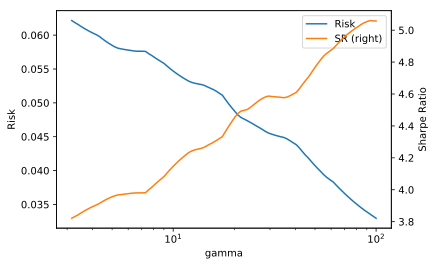

In [138]:
ax = gamma_chart[['gamma','Risk','SR']].plot(x=['gamma'], secondary_y=['SR'], logx=True)
ax.set_ylabel('Risk')
ax.right_ax.set_ylabel('Sharpe Ratio');

In [139]:
net_exposures = np.arange(0.0, 1.01, 0.2)
left_substr = lambda a, i: [c[:i] for c in a.columns.tolist()]
# summary plots
def plot_bt_summary(df):
    pct_chg_df = df.pct_change()
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,3), dpi=300)
    compound(df).plot(ax=ax1, x_compat=True)
    ax1.yaxis.set_label('Indexed Return')
    pct_chg_df.plot.hist(ax=ax2, stacked=True, bins=20)
    pct_chg_df.boxplot(ax=ax3)
    pct_chg_df.plot.kde(ax=ax4)
    print(pct_chg_df.describe())

             0.0        0.2        0.4        0.6        0.8        1.0
count  60.000000  60.000000  60.000000  60.000000  60.000000  60.000000
mean    0.002451   0.002294   0.002128   0.001870   0.002242   0.001278
std     0.006732   0.006811   0.007243   0.008012   0.007646   0.010839
min    -0.027746  -0.027746  -0.026840  -0.029295  -0.029424  -0.037440
25%    -0.000573  -0.000604  -0.001307  -0.002205  -0.001493  -0.003777
50%     0.002086   0.001974   0.002263   0.002756   0.000295   0.003005
75%     0.005979   0.005990   0.006534   0.006805   0.007480   0.007309
max     0.016471   0.016471   0.013804   0.017236   0.019138   0.022679


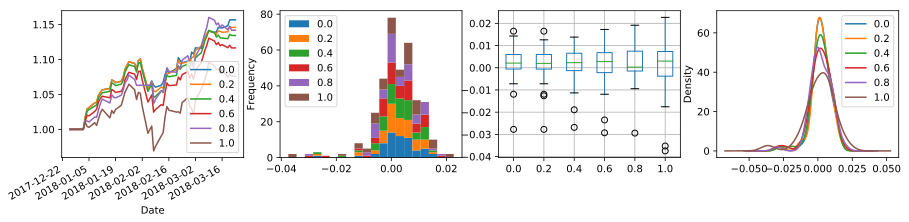

In [140]:
# 3. what is the optimal net exposure, weekly rebalance for 2018, does it change over time?
time_frame = '2017-12-25'; rebal_frequency = 'W-WED'
subset = consol_px[time_frame:]
backtest_path = './backtests/'
fname = backtest_path + 'net_exp_port ' + time_frame + ' ' + rebal_frequency + '.csv'

try:
    net_exp_portfolios = pd.read_csv(fname, index_col='Date', parse_dates=True)
    net_exp_portfolios.columns = left_substr(net_exp_portfolios, 3)
    plot_bt_summary(net_exp_portfolios)
    # conclusion: see that the net exposure equal to zero acheives the best return with the smallest drawdown
    
except Exception as err:
    print("Error: {0}, please run backtest below".format(err))
    # this will take a while
    net_exp_portfolios = pd.DataFrame([])
    log = True
    for ne in net_exposures:
        net_exposure = ne
        hist_allocs = get_hist_allocs(rebal_frequency, subset, lookback, gamma_vals, min_len, pos_filter)
        returns, allocs = align_ret_allocs(hist_allocs, subset)
        time_series = calc_port_performance(returns, allocs).to_frame()
        time_series.columns = [ne]
        net_exp_portfolios = net_exp_portfolios.combine_first(time_series.copy())
    net_exp_portfolios.to_csv(fname)

               0.0          0.3          0.6          0.8
count  2578.000000  2578.000000  2578.000000  2578.000000
mean      0.000024     0.000190     0.000265     0.000308
std       0.009277     0.007329     0.007582     0.006058
min      -0.107485    -0.086274    -0.085452    -0.035330
25%      -0.003182    -0.003107    -0.003000    -0.002285
50%       0.000000     0.000321     0.000352     0.000321
75%       0.003864     0.004058     0.003998     0.003326
max       0.059969     0.034042     0.049426     0.038923


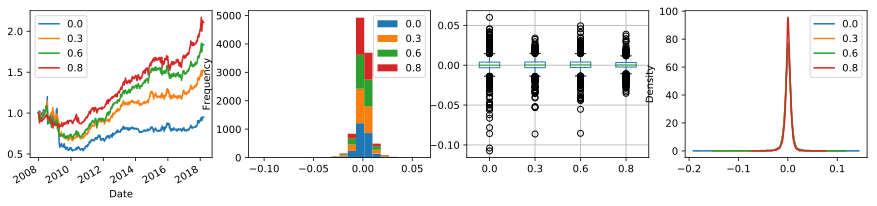

In [141]:
# 4. what is the optimal net exposure monthly and quarterly?
time_frame = '2007-12-25'; rebal_frequency = 'BM'
subset = consol_px[time_frame:]
fname = backtest_path + 'net_exp_port ' + time_frame + ' ' + rebal_frequency + '.csv'

try:
    net_exp_portfolios = pd.read_csv(fname, index_col='Date', parse_dates=True)
    net_exp_portfolios.columns = left_substr(net_exp_portfolios, 3)
    plot_bt_summary(net_exp_portfolios)
    # conclusion: slow rebalances underperforms the benchmark, too slow to adapt

except Exception as err:
    print("Error: {0}, please run backtest below".format(err))
    # this will take a while
    log = True
    net_exp_portfolios = pd.DataFrame([])
    for ne in net_exposures:
        net_exposure = ne
        hist_allocs = get_hist_allocs(rebal_frequency, subset, lookback, gamma_vals, min_len, pos_filter)
        returns, allocs = align_ret_allocs(hist_allocs, subset)
        time_series = calc_port_performance(returns, allocs).to_frame()
        time_series.columns = [ne]
        net_exp_portfolios = net_exp_portfolios.combine_first(time_series.copy())
    net_exp_portfolios.to_csv(fname)

               0.0          0.2          0.4          0.6          0.8  \
count  2578.000000  2578.000000  2578.000000  2578.000000  2578.000000   
mean     -0.000015    -0.000002     0.000029     0.000068     0.000194   
std       0.009091     0.007330     0.007342     0.007846     0.007076   
min      -0.103900    -0.093156    -0.082659    -0.085452    -0.047685   
25%      -0.003407    -0.002780    -0.003242    -0.002988    -0.002698   
50%       0.000163     0.000000     0.000169     0.000000     0.000314   
75%       0.004040     0.003350     0.003732     0.003849     0.003819   
max       0.058988     0.040107     0.045605     0.051410     0.035647   

               1.0  
count  2578.000000  
mean      0.000287  
std       0.006536  
min      -0.033783  
25%      -0.002237  
50%       0.000359  
75%       0.003289  
max       0.044955  


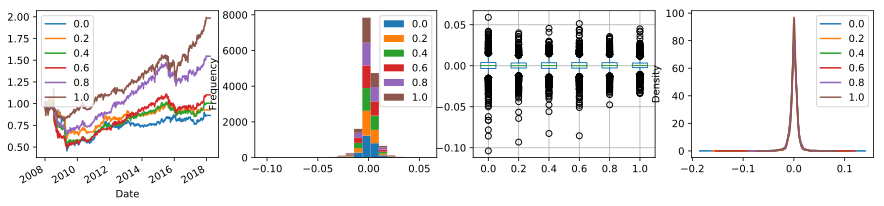

In [142]:
# 4. what is the optimal net exposure monthly and quarterly?
time_frame = '2007-12-25'; rebal_frequency = 'BQ'
subset = consol_px[time_frame:]
fname = backtest_path + 'net_exp_port ' + time_frame + ' ' + rebal_frequency + '.csv'

try:
    net_exp_portfolios = pd.read_csv(fname, index_col='Date', parse_dates=True)
    net_exp_portfolios.columns = left_substr(net_exp_portfolios, 3)
    plot_bt_summary(net_exp_portfolios)
    # conclusion: slow rebalances underperforms the benchmark, too slow to adapt

except Exception as err:
    print("Error: {0}, please run backtest below".format(err))
    # this will take a while
    log = True
    net_exp_portfolios = pd.DataFrame([])
    for ne in net_exposures:
        net_exposure = ne
        hist_allocs = get_hist_allocs(rebal_frequency, subset, lookback, gamma_vals, min_len, pos_filter)
        returns, allocs = align_ret_allocs(hist_allocs, subset)
        time_series = calc_port_performance(returns, allocs).to_frame()
        time_series.columns = [ne]
        net_exp_portfolios = net_exp_portfolios.combine_first(time_series.copy())
    net_exp_portfolios.to_csv('net_exp_port ' + time_frame + ' ' + rebal_frequency + '.csv')

               0.0          0.2          0.4          0.6          0.8  \
count  2578.000000  2578.000000  2578.000000  2578.000000  2578.000000   
mean      0.001061     0.000986     0.000995     0.000943     0.000819   
std       0.009046     0.007940     0.007310     0.006691     0.005893   
min      -0.108755    -0.095344    -0.071093    -0.060440    -0.040560   
25%      -0.002348    -0.002265    -0.002109    -0.002062    -0.001989   
50%       0.001106     0.001093     0.001191     0.001095     0.000851   
75%       0.004818     0.004637     0.004531     0.004410     0.003913   
max       0.069484     0.058998     0.047864     0.037589     0.033290   

               1.0  
count  2578.000000  
mean      0.000682  
std       0.005193  
min      -0.038642  
25%      -0.001689  
50%       0.000669  
75%       0.003261  
max       0.030534  


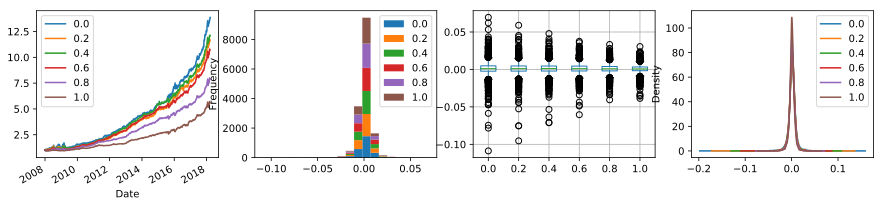

In [143]:
# 3. what is the optimal net exposure, weekly rebalance for 2018, does it change over time?
log = True
time_frame = '2007-12-25'; rebal_frequency = 'W-WED'
subset = consol_px[time_frame:]
fname = backtest_path + 'net_exp_port ' + time_frame + ' ' + rebal_frequency + '.csv'

try:
    net_exp_portfolios = pd.read_csv(fname, index_col='Date', parse_dates=True)
    net_exp_portfolios.columns = left_substr(net_exp_portfolios, 3)
    plot_bt_summary(net_exp_portfolios)
    # conclusion: see that the 0 net exposure acheives the best "cumulative" returns
    # however, there are a fair amount of outliers in the boxplot
    # need to decompose into years to understand the behaviour

except Exception as err:
    print("Error: {0}, please run backtest below".format(err))
    # this will take a while
    log = True
    net_exp_portfolios = pd.DataFrame([])
    for ne in net_exposures:
        net_exposure = ne
        hist_allocs = get_hist_allocs(rebal_frequency, subset, lookback, gamma_vals, min_len, pos_filter)
        returns, allocs = align_ret_allocs(hist_allocs, subset)
        time_series = calc_port_performance(returns, allocs).to_frame()
        time_series.columns = [ne]
        net_exp_portfolios = net_exp_portfolios.combine_first(time_series.copy())
    net_exp_portfolios.to_csv(fname)

In [144]:
net_exposures = np.arange(0.0, 1.01, 0.2)
left_substr = lambda a, i: [c[:i] for c in a.columns.tolist()]
# summary plots
def plot_bt_summary(df):
    pct_chg_df = df.pct_change()
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,3), dpi=300)
    compound(df).plot(ax=ax1, x_compat=True)
    ax1.yaxis.set_label('Indexed Return')
    pct_chg_df.plot.hist(ax=ax2, stacked=True, bins=20)
    pct_chg_df.boxplot(ax=ax3)
    pct_chg_df.plot.kde(ax=ax4)
    print(pct_chg_df.describe())

              0.0         0.2         0.4         0.6         0.8         1.0
count  252.000000  252.000000  252.000000  252.000000  252.000000  252.000000
mean     0.001063    0.000661    0.000576    0.000225    0.000411   -0.000207
std      0.016164    0.013881    0.011974    0.010529    0.008104    0.004107
min     -0.078338   -0.075187   -0.071093   -0.060440   -0.029236   -0.033036
25%     -0.005584   -0.004574   -0.004516   -0.004318   -0.003538   -0.001506
50%      0.000446    0.000067    0.001350    0.000699    0.000265    0.000000
75%      0.008835    0.007880    0.006809    0.006074    0.004643    0.001650
max      0.069484    0.058998    0.047864    0.029019    0.027997    0.013926
              0.0         0.2         0.4         0.6         0.8         1.0
count  251.000000  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.001013    0.000460    0.000852    0.001045    0.000439    0.000609
std      0.015899    0.013296    0.012374    0.010237    0.00756

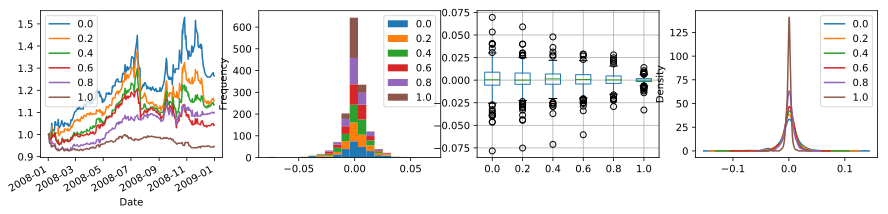

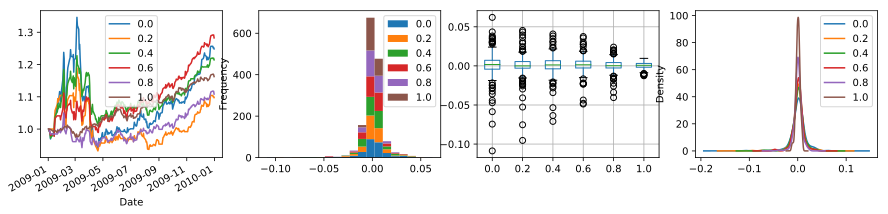

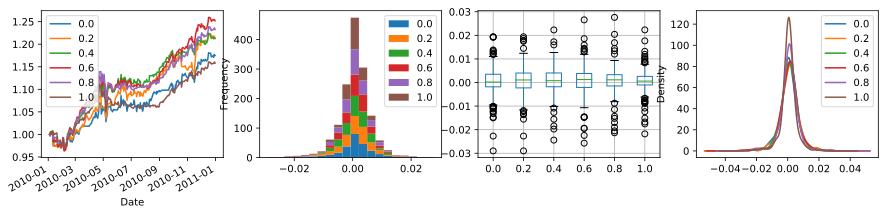

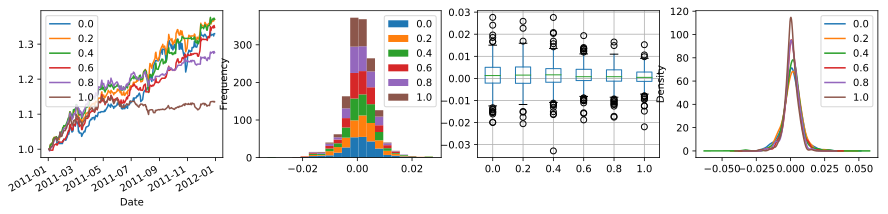

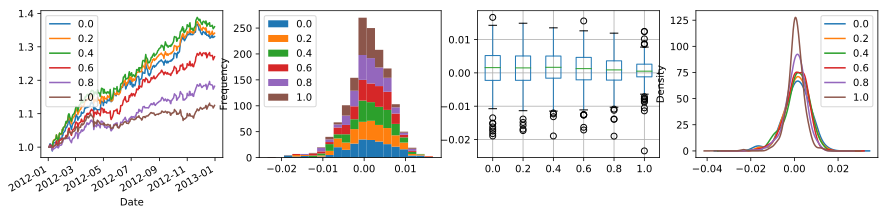

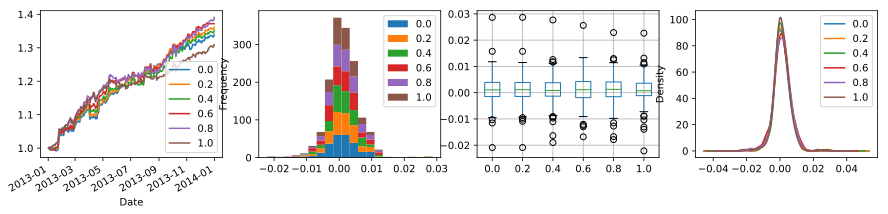

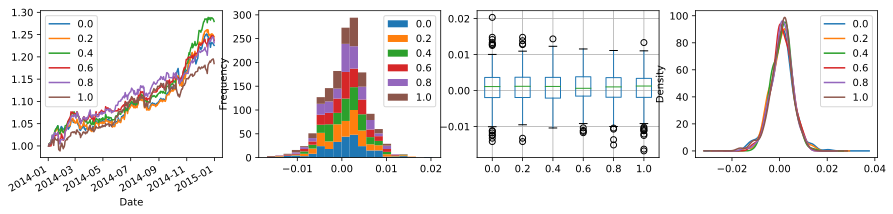

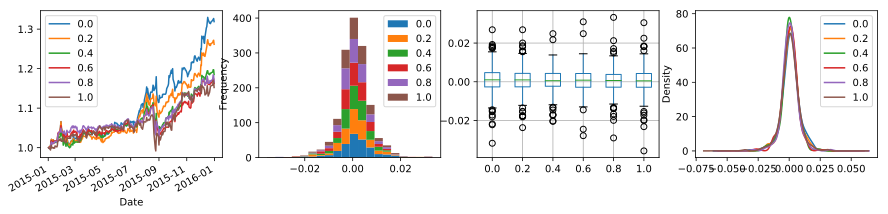

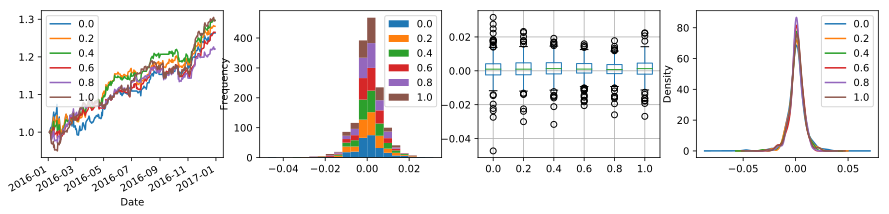

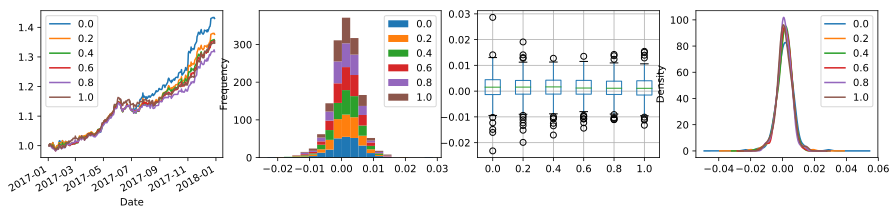

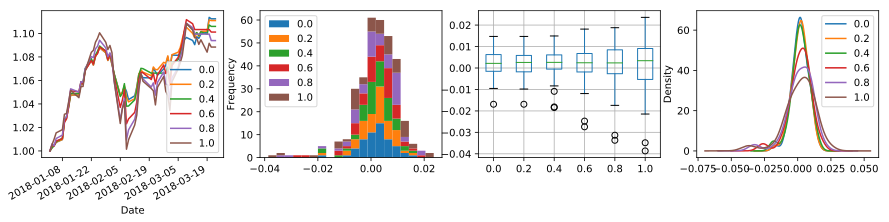

In [145]:
# decompose the performance into years to understand the behavior of each net exposure portfolio
net_exp_portfolios = pd.read_csv(fname, index_col='Date', parse_dates=True)
net_exp_portfolios.columns = left_substr(net_exp_portfolios, 3)
years = net_exp_portfolios.index.year.drop_duplicates()
nbr_charts = len(sorted(years)); cols = 5
#fig, ax = plt.subplots(nbr_charts // cols, cols, figsize=(12,6), sharey=True)
#for i, axi in enumerate(ax.flat):
for i in years:
    if i < 2008: continue
    year_df = net_exp_portfolios.loc[str(i)] 
    #indexed = compound(year_df)
    #x_list = np.arange(len(year_df.index))
    #axi.plot(x_list, indexed.values)
    plot_bt_summary(year_df)
# conclusions: WIP, fixed exposures does work every year, need to dynamically determine with argmax

/Users/vicveiga/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


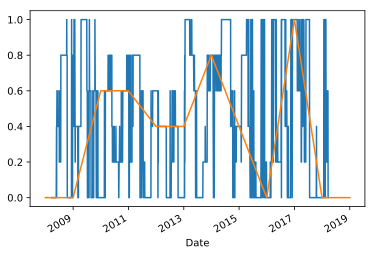

In [146]:
# what is the best net exposure by year, is it dynamic?
roll3M = (net_exp_portfolios / net_exp_portfolios.shift(60)) - 1
cum_period_return = net_exp_portfolios.pct_change().resample('A').sum()
best_ne = lambda x: np.argmax(x)
roll3M.apply(best_ne, axis='columns').astype(np.float).plot()
ax = cum_period_return.apply(best_ne, axis='columns').astype(np.float).plot()
# conclusions: WIP, yes, best returns come from adjusting net exposures overtime
# need to come up with a framework to adjust net exposure to maximize returns